In [1]:
import os
os.chdir('../')

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from data_pipeline import Pipeline
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate performance metrics for classification.

    Parameters:
    - y_true: The true labels.
    - y_pred: The predicted labels by the model.

    Returns:
    A dictionary with the calculated metrics.
    """
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),  # squared=False to get RMSE
        'R^2': r2_score(y_true, y_pred)
    }
    return metrics

In [4]:
df = pd.read_csv('amazon_movie_reviews.csv') 

/tmp/ipykernel_1574/1828681962.py:1: DtypeWarning: Columns (18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('amazon_movie_reviews.csv')


In [5]:
n_samples = 5000 
min_count = df['rating'].value_counts().min()  # Find the minimum count to ensure we don't sample more than available
n_samples = min(n_samples, min_count)  # Adjust n_samples to the feasible maximum
print(n_samples)
# Perform stratified sampling
df = df.groupby('rating').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

5000


In [6]:
pipeline = Pipeline()
transformed_data = pipeline.transform(df)

In [7]:
X = transformed_data.drop(['rating', 'polarity'], axis=1)  # Drop the rating and polarity to avoid leakage
y = transformed_data['polarity']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(y_train)

23311    0.500000
23623    0.000000
1020    -0.400000
12645    0.144231
1533     0.000000
           ...   
21575    0.468750
5390    -0.100000
860      0.037179
15795    0.119572
23654    0.750000
Name: polarity, Length: 20000, dtype: float64


In [10]:
print(X_train)

       helpful_vote  verified_purchase  review_length  word_count  \
23311     -0.133816                  1             22           4   
23623     -0.133816                  1             79          15   
1020      -0.133816                  1             28           3   
12645     -0.133816                  1            601         106   
1533      -0.133816                  1              8           1   
...             ...                ...            ...         ...   
21575     -0.047053                  1             82          13   
5390       0.299999                  1            200          36   
860        0.733814                  1            473          81   
15795     -0.133816                  1            937         162   
23654     -0.133816                  1             80          14   

       unique_word_count  punctuation_count  subjectivity         0         1  \
23311                  4                  2      0.600000  8.988703  9.002715   
23623    

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define regression models
models = {
#     "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.5, solver='auto'),
    "Lasso Regression": Lasso(alpha=0.1, max_iter=10000, tol=0.0001),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50),
    "SVR": SVR(C=1.0, epsilon=0.1)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on the test data
    metrics = calculate_metrics(y_test, y_pred)  # Use the regression metrics function defined earlier
    results[name] = metrics
    print(f"Metrics for {name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Metrics for Ridge Regression:
MAE: 0.1903
MSE: 0.0654
RMSE: 0.2558
R^2: 0.4285
Metrics for Lasso Regression:
MAE: 0.2485
MSE: 0.1095
RMSE: 0.3309
R^2: 0.0438
Metrics for Random Forest Regressor:
MAE: 0.1475
MSE: 0.0461
RMSE: 0.2146
R^2: 0.5976
Metrics for SVR:
MAE: 0.2313
MSE: 0.0964
RMSE: 0.3105
R^2: 0.1579


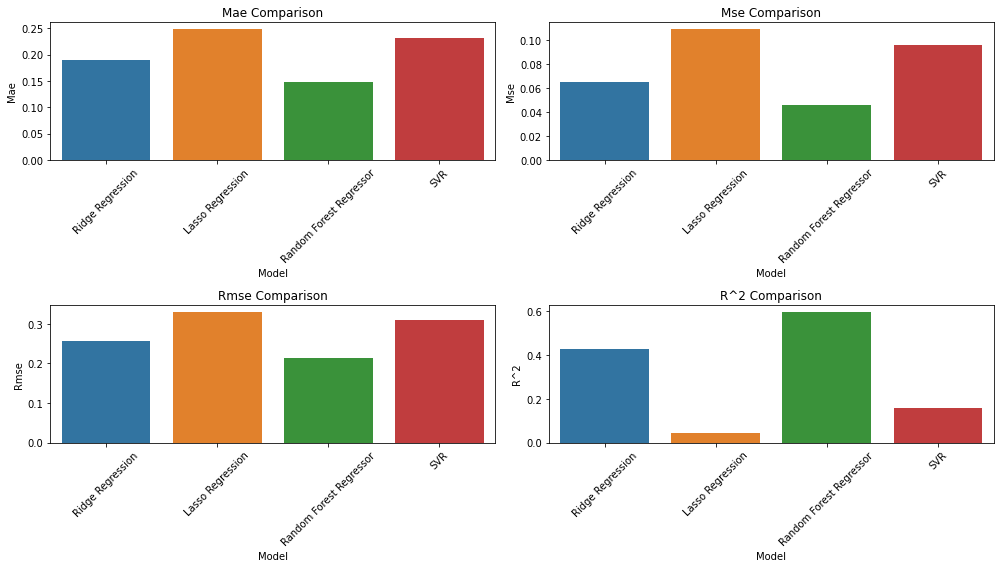

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(results):
    # Convert the results dictionary to a DataFrame for easier plotting
    metrics_df = pd.DataFrame(results).T  # Transpose to get models as rows
    metrics_df = metrics_df.reset_index()
    metrics_df.rename(columns={'index': 'Model'}, inplace=True)

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 8))

    # Create a subplot for each metric
    for i, metric in enumerate(['MAE', 'MSE', 'RMSE', 'R^2'], 1):
        plt.subplot(2, 2, i)
        sns.barplot(x='Model', y=metric, data=metrics_df)
        plt.title(f'{metric.capitalize()} Comparison')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Model')
        plt.xticks(rotation=45)  # Rotate model names for better readability

    plt.tight_layout()
    plt.show()

# Assuming 'results' is the dictionary with your model metrics
plot_results(results)

Overall my models performance was less than ideal. However, with that said I am still thinking the Random Forest Regressor will be useful. I think this for a few reasons. The Big thing to keep in mind is that this is predicting a number from -1 to 1, with 6 digits after the decimal. While it may not have been insanely accurate I believe the model will still be capable of understanding the sentiment of the review. Not only that but I did only train it on 50 estimators, moving it up will more than likely help the performance. Besides that we can see that it outperformed in every category that I tested for. 